Hidden Markov Model (HMM) is a statistical Markov model in which the system being modeled is assumed to be a Markov process with unobserved (i.e. hidden) states. Observed data is our market features, hidden states are our market behavior.


It is simple enough. But also its rich enough. 

We can use it as a baseline model. 

https://www.youtube.com/watch?v=TPRoLreU9lA

In [2]:
import quandl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy
import datetime
import json
import seaborn as sns
import joblib
import quandl
from dateutil.relativedelta import relativedelta

import yfinance as yf
import plotly.express as px
from statistics import mode

import numpy as np
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

## load data

In [6]:
vix_df = pd.read_pickle('/data/workspace_files/data_vix.pickle') 
rf_df = pd.read_pickle('/data/workspace_files/data_rf.pickle') 
fut_return = pd.read_pickle('/data/workspace_files/data_fut_return.pickle') 

# PCA

In [7]:
def pca_algo(data_df):
    x92 = StandardScaler().fit_transform(data_df) #standardize 
    pca_transformer = PCA()
    pca_transformer.fit(x92)
    px.line(pd.DataFrame(pca_transformer.explained_variance_ratio_).cumsum())

    pca_model = PCA(n_components=20).fit(x92)
    pca_data = pca_model.transform(x92)
    pca_data = pd.DataFrame(pca_data, index=data_df.index)
    return pca_data

## SPARSE PCA 

In [8]:
def spca_algo(data_df):
    x92 = StandardScaler().fit_transform(data_df) #standardize 
    spca_transformer = SparsePCA(n_components=12, alpha=1., random_state=0)
    spca_transformer.fit(x92)
    spca_data = spca_transformer.transform(x92)
    spca_data = pd.DataFrame(spca_data, index=data_df.index)
    return spca_data

# HMM Model 

In [9]:
def plot_hidden_states(model, data, X, close_series, fut_ret_series):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, model.n_components))
    hidden_states = model.predict(X)

    print(data.shape, X.shape, close_series.shape, fut_ret_series.shape)

    ret_list = []
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, close_series, c = 'grey')
        ax[0].plot(data.index[mask], close_series[mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(fut_ret_series[mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        cum_return = (fut_ret_series[mask] + 1).cumprod()
        ax[2].plot(cum_return, c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        ret_list.append(cum_return.iloc[-1].squeeze())
    plt.tight_layout()
    return ret_list

In [10]:
# Brute force modelling
def hmm_model(data, state, max_iter = 10000):    
    best_model = GaussianHMM(n_components = state, 
                             random_state = 100,
                             covariance_type = "full", n_iter = max_iter).fit(data)
    return best_model

In [11]:
def get_data(mtype, data_df):
    if mtype == "spca":
        spca_data = spca_algo(data_df)
        return spca_data.copy()
    elif mtype == "pca":
        pca_data = pca_algo(data_df)
        return pca_data.copy()
    elif type(mtype)==list:
        return data_df[mtype].copy()

def train_hmm_model(train_data, data_df, close_data, fut_return, filen):
    train_ind = int(np.where(train_data.index >= pd.to_datetime('2018-01-01 00:00:00'))[0][0])
    train_set = train_data.iloc[:train_ind]
    test_set = train_data.iloc[train_ind:]
    test_set_orig = data_df.loc[test_set.index]
    print("train set size is ", train_set.shape[0], ", test set size is ", test_set.shape[0])

    model = hmm_model(train_set, state=3, max_iter=1000000)
    print("Best model with {0} states ".format(str(model.n_components)))

    rets = plot_hidden_states(model, 
                    data_df.iloc[:train_ind], 
                    train_set, 
                    close_data[:train_ind], 
                    fut_return.iloc[:train_ind])

    test_hidden_states = model.predict(test_set)

    bear_id = rets.index(min(rets))
    bull_id = rets.index(max(rets))
    neutral_id = 3 - bear_id - bull_id
    print("bull", bull_id, " bear", bear_id, " neutral", neutral_id)

    states =    {"bear": bear_id,
                  "bull": bull_id,
                  "static": neutral_id}
    
    signal_map = {v: k for k, v in states.items()}
    test_set_res = train_data.iloc[train_ind:]
    test_orig_data = data_df.loc[train_data.index][train_ind:]

    test_orig_data['signal'] = test_hidden_states
    test_set_res['signal'] = test_hidden_states
    actions = np.select([
            (test_orig_data[['signal']] == states['bull']),
            (test_orig_data[['signal']] == states['bear']),
            (test_orig_data[['signal']] == states['static'])],
            [1, -1, 0]
        )
    test_set_res['weight'] = actions

    train_h = pd.DataFrame(model.predict(train_set), columns=['signal'], index=train_set.index)
    train_out = pd.DataFrame(np.select([
                            (train_h[['signal']] == states['bull']),
                            (train_h[['signal']] == states['bear']),
                            (train_h[['signal']] == states['static'])],
                            [1, -1, 0]
                        ), 
                index=train_set.index)
    train_out.to_pickle('/data/workspace_files/output/hmm_%s_train.pickle'%filen)

    out = pd.DataFrame(test_set_res['weight'], index=test_set.index)
    out.to_pickle('/data/workspace_files/output/hmm_%s_test.pickle'%filen)

    plot_hidden_states(model, 
                    data_df.iloc[train_ind:], 
                    test_set, 
                    close_data.iloc[train_ind:], 
                    fut_return.iloc[train_ind:])
    
    return rets, model, test_set_res, test_set_orig


train set size is  1351 , test set size is  210
Best model with 3 states 
(1351, 1) (1351, 1) (1351, 1) (1351, 1)
bull 0  bear 1  neutral 2
(210, 1) (210, 1) (210, 1) (210, 1)


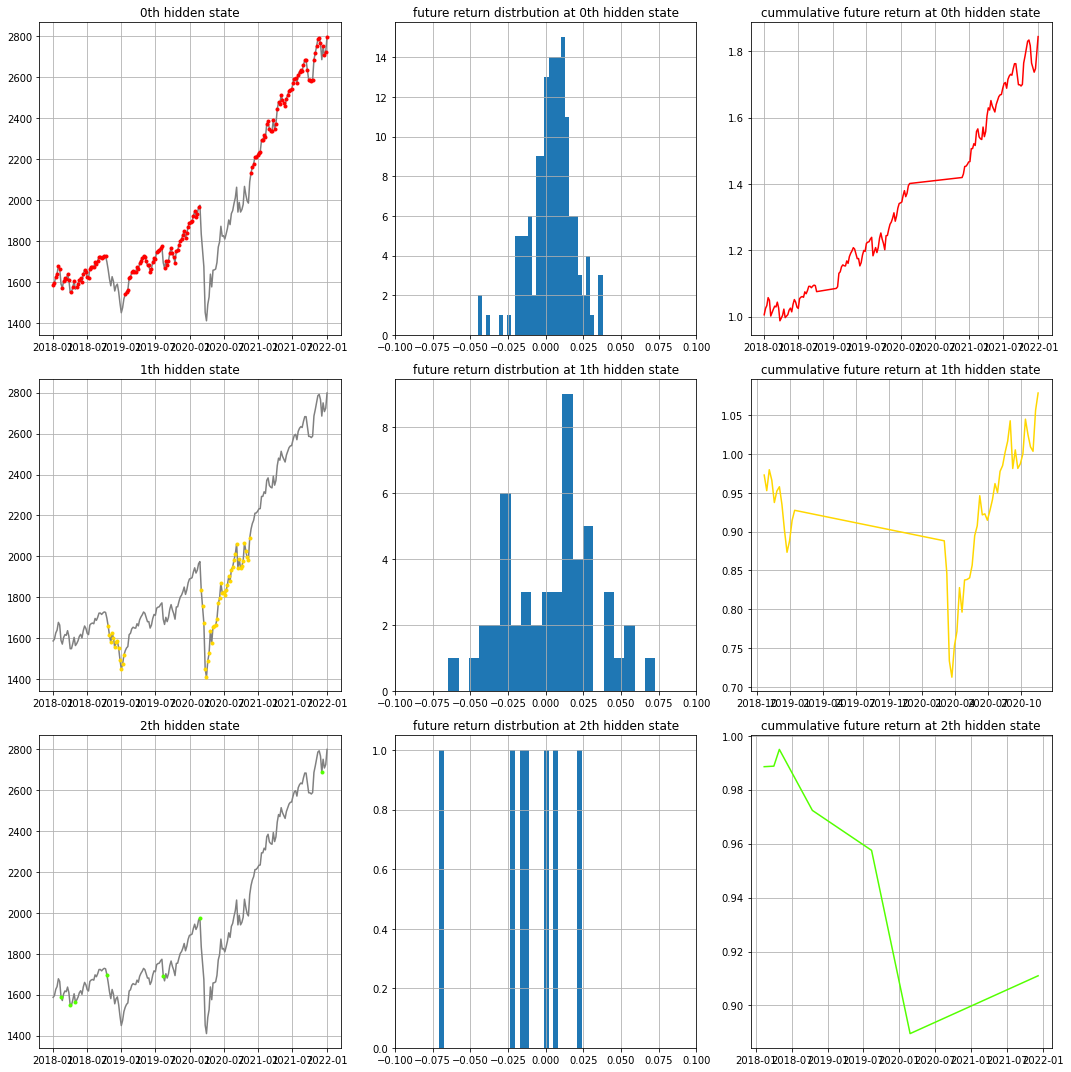

In [12]:
### Baseline
data_df92 = pd.read_pickle('/data/workspace_files/data_df92.pickle')
close_data92 = data_df92[['Close']]
data_df92 = data_df92[['last_return']]
fut_return92 = fut_return.loc[data_df92.index]

rets, model, test_set_res, test_set_orig = train_hmm_model(data_df92, 
                                                           data_df92, 
                                                           close_data92, 
                                                           fut_return92,
                                                           "baseline")

# Trading Strategy

In [15]:
data_df92 = pd.read_pickle('/data/workspace_files/data_df92.pickle')
close_data92 = data_df92[['Close']]
data_df92 = data_df92.drop(columns=['Close', 'future_return'])
fut_return92 = fut_return.loc[data_df92.index]

rets, model, test_set_res, test_set_orig = train_hmm_model(get_data("spca", data_df92), 
                                                           data_df92, 
                                                           close_data92, 
                                                           fut_return92,
                                                           "spca92")

rets, model, test_set_res, test_set_orig = train_hmm_model(get_data("pca", data_df92), 
                                                           data_df92, 
                                                           close_data, 
                                                           fut_return92,
                                                           "pca92")


last_return = ['last_return']
rets, model, test_set_res, test_set_orig = train_hmm_model(get_data(last_return, data_df92), 
                                                           data_df92, 
                                                           close_data, 
                                                           fut_return92,
                                                           "last_return")


data_df99 = pd.read_pickle('/data/workspace_files/data_df99.pickle')
close_data99 = data_df99[['Close']]
data_df99 = data_df99.drop(columns=['Close'])
fut_return99 = fut_return.loc[data_df99.index]
rets, model, test_set_res, test_set_orig = train_hmm_model(get_data("spca", data_df99), 
                                                           data_df99, 
                                                           close_data99, 
                                                           fut_return99,
                                                           "spca99")